## Note: mode1-taxi, mode2-FHV, mode3-shared FHV, mode4-PT, mode5-walking

In [4]:
import numpy as np
import pandas as pd
import warnings
random_seed = 1
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

Suggestions from Stan @ July_17

* tune parameter with sampling taxi zone (large pop); do both for MSE and Weightening one; and store all history of tuning parameters

* comapre the population of all modes for all zones with ACS, plotting bar chart

### Zero scnario outcome

In [5]:
# tax = (acs['P(mode1)'].sum())*2.75 + (acs['P(mode2)'].sum())*2.5 + (acs['P(mode3)'].sum())*0.85
# tax

## Data Preparation

In [6]:
acs = pd.read_csv('final_acs_transportation_choice.csv')
acs.head()

,taxi_zone,P(mode1),P(mode2),P(mode3),P(mode4),P(mode5),P(mode6)
0,3.0,0.115434,17.843262,7.334361,3885.402712,478.622467,4316.681764
1,4.0,42.851015,140.891180,84.609811,6937.780033,2631.714648,779.153313
2,5.0,0.081377,13.158607,2.120444,1860.706347,40.495673,6312.437553
3,6.0,0.109017,7.637848,1.878344,1974.772111,198.118892,3086.483787
4,7.0,25.522468,142.614028,37.582529,28436.765508,2680.397880,5365.117587


In [7]:
mode_data = pd.read_csv('final_allMode_with_2017wage_cleaned_update.csv', index_col=0)
mode_data = mode_data.dropna()
print(mode_data.shape)
mode_data.head()

(298632, 18)


,DOlocationID,ODpair,PUlocationID,duration,mode,nest,price,2500,7500,12500,17500,22500,30000,42500,62500,87500,125000,225000
0,4,3-4,3,39.695000,2,1,64.000,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.93859,0.586936,0.740725,0.514005
1,4,3-4,3,45.216667,3,1,61.500,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.93859,0.586936,0.740725,0.514005
2,4,3-4,3,83.000000,4,2,5.500,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.93859,0.586936,0.740725,0.514005
3,4,3-4,3,225.933333,5,3,0.000,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.93859,0.586936,0.740725,0.514005
4,4,3-4,3,39.695000,6,4,9.424,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.93859,0.586936,0.740725,0.514005


## Modeling

### Nested Logit Model

In [8]:
def utility(mode, wage, Lambda, dataset):
    '''
    Get the utility for mode j under specific OD pair
    Lambda: parameter that trade-off different transportation mode
    '''
    subset = dataset[dataset['mode'] == mode]
    vj = Lambda * (float(int(wage)/124800) * float(subset['duration']) + float(subset['price'])) #124800: convert wage scale 'year' to 'minitues'. 52 weeks * 5 workdays/week * 8 hrs/day * 60 mins/hour = 124800 minutes
    return -vj 


def InclusiveValue(Nk, Tk, wage, dictVj, Lambda, dataset):
    '''
    Get the inclusive value for nest K
    Nk:nest k
    T: the dict that contains Tao(dissmilarity parameter) for each Nest. for example, Tk meeas Tao for nest K
    '''
    subsetNk = dataset[dataset['nest'] == Nk]
    modes = list(subsetNk['mode'].unique()) #what modes contained in this nest k
    sumIV = 0
    for j in modes:   
        vj = utility(j, wage, Lambda, subsetNk)
        dictVj[j] = vj
        sumIV += np.exp((1/Tk)*vj)  
    IVk = np.log(sumIV)
    return dictVj, IVk
    

def denoSum(T, nestList, wage, Lambda, dataset):
    '''
    Calculate the denomenator for P(y=Nk)
    T: the dict that contains Tk for each Nest, in our case T={1:T1, 2:T2, 3:T3}; T1, T2, T3 defined by us 
    TotK: the total number of nest this model has, in our case TotK = 3
    '''
    deno = 0
    dictIVk = {}
    dictVj = {}
    for Nk in nestList: #k is the k Nest, in our case k=1,2,3
        Tk = T[Nk] #get the tao for nest k 
        dictVj, IVk = InclusiveValue(Nk, Tk, wage, dictVj, Lambda, dataset)
        denok = np.exp(Tk*IVk)
        deno += denok
        dictIVk[Nk] = IVk
    return dictVj, dictIVk, deno


def probability (j, Nk, T, dictVj, dictIVk, deno):  
    '''
    Calculate the probability for the specific mode j and Nest Nk
    '''
    Tk = T[Nk]
    IVk = dictIVk[Nk]
    vj = dictVj[j]
    pjk = np.exp((1/Tk)*vj)/np.exp(IVk) #pjk: P(y=j, y belong to Nk)
    pk = np.exp(Tk*IVk)/deno #pk: P(y belong to Nk)
    pj = pjk*pk #pj: P(y=j)
    return pj

### Apply to our case

In [181]:
def apply_model(T, totmode, wageList, Lambda, dataAll):
    '''
    apply to our case
    '''
    import timeit
    start = timeit.default_timer()

    ODpair_list = list(dataAll.ODpair.unique())
    p = []
    loss_function_deno = []
    pop_wage = [] #store the population under od and wage
    for od in ODpair_list: #indentify OD pair  
        dataOD = dataAll[dataAll.ODpair==od] 
        modeList = list(dataOD['mode'])
        nestList = list(dataOD['nest'])
        
        pop_OD = [] #store the results under each OD pair
        loss_function_deno_OD = [] #store the denominator of the loss function under each OD pair
        
        for wage in wageList:            
            dictVj, dictIVk, deno = denoSum(T, set(nestList), wage, Lambda, dataOD)
            pop_mode = [] #store the population results under each OD pair and each wage
            loss_function_deno_mode = [] #store the deno of loss function under each OD pair and each wage
            pop_wage_mode = [od, wage] #store the population for each wage
            for i in range(1,totmode+1):
                if i in modeList: #not all modes appear in every OD pair
                    prob = probability(i, nestList[modeList.index(i)], T, dictVj, dictIVk, deno) #probability under OD pari and mode i
                    if np.isnan(prob) == True: #if predicted probability is nan, replace it as 0, means no people choose
                        prob = 0
                    
                    pop = dataOD[wage].mean() * prob
                    loss_function_denoi = dataOD[wage].mean() * (prob - prob**2)               
                    pop_mode.append(pop)
                    pop_wage_mode.append(prob)
                    loss_function_deno_mode.append(loss_function_denoi)
                    
                else: 
                    pop_mode.append(0) #the probability of mode which not in the modeList is also 0
                    pop_wage_mode.append(0)
                    loss_function_deno_mode.append(0)
                    #pop_mode.append(1)
            pop_OD.append((pop_mode)) #the shape of pop_OD is len(wageList) * 5 
            pop_wage.append(pop_wage_mode)
            loss_function_deno_OD.append(loss_function_deno_mode)
        pop_OD_sum = [sum(x) for x in zip(*pop_OD)] #sum the population of each wage 
        loss_function_deno_sum = [sum(x) for x in zip(*loss_function_deno_OD)]
        p.append(pop_OD_sum)
        loss_function_deno.append(loss_function_deno_sum)

    df = pd.DataFrame(p, columns=['P(mode1)', 'P(mode2)', 'P(mode3)', 'P(mode4)', 'P(mode5)', 'P(mode6)']
                      , index=ODpair_list)
    df_LF_deno = pd.DataFrame(loss_function_deno, columns=['mode1', 'mode2', 'mode3', 'mode4', 'mode5', 'mode6']
                               , index=ODpair_list)
    
    df_pop_wage = pd.DataFrame(pop_wage, columns=['ODpair', 'wage', 'P(mode1)', 'P(mode2)', 'P(mode3)', 'P(mode4)', 
                                                  'P(mode5)', 'P(mode6)'])
    
    stop = timeit.default_timer()
    timeslot = stop - start
    return df, df_LF_deno, df_pop_wage, timeslot


def compare_with_ground_truth(predictdf, loss_function_deno, truedf):
    '''
    compare our predicted transportation choice with ground truth
    
    The header of the datafrme after merge (named 'data_compare') should be like:
    taxi_zone | P(mode1)_x | P(mode2)_x | P(mode3)_x | P(mode4)_x | P(mode5)_x | P(mode1)_y | P(mode2)_y | P(mode3)_y | P(mode4)_y | P(mode5)_y
    '''
    import numpy as np
    # makesure predictdf and truedf have the same formats
    for col in predictdf.columns:
        predictdf[col] = predictdf[col].astype(float) 
    predictdf = predictdf.fillna(0)
    predictdf = predictdf.replace([np.inf, -np.inf], np.nan)
    predictdf = predictdf.dropna()
    predictdf['taxi_zone'] = predictdf.index.map(lambda x: x.split('-')[0]) #get origin taxi zone from each OD pair
    predictdf = predictdf.groupby('taxi_zone').sum().reset_index() #group the popuation by taxi zone
    predictdf['taxi_zone'] = predictdf['taxi_zone'].astype(int)
    
    #do same thing as predictdf to loss_function_deno dataframe
    for col in loss_function_deno.columns:
        loss_function_deno[col] = loss_function_deno[col].astype(float) 
    loss_function_deno = loss_function_deno.fillna(0)
    loss_function_deno = loss_function_deno.replace([np.inf, -np.inf], np.nan)
    loss_function_deno = loss_function_deno.dropna()
    loss_function_deno['taxi_zone'] = loss_function_deno.index.map(lambda x: x.split('-')[0]) #get origin taxi zone from each OD pair
    loss_function_deno = loss_function_deno.groupby('taxi_zone').sum().reset_index() #group the popuation by taxi zone
    loss_function_deno['taxi_zone'] = loss_function_deno['taxi_zone'].astype(int)   
    
    truedf['taxi_zone'] = truedf['taxi_zone'].astype(int)
    
    data_compare = pd.merge(predictdf, truedf, left_on='taxi_zone', right_on = 'taxi_zone')
#     data_compare = pd.merge(predictdf, truedf, left_on='taxi_zone', right_on = 'taxi_zone', how='left')
    data_compare = data_compare.dropna()  #some zone in predictdf are not exist in acs!!!!?????
    data_compare_zone = data_compare['taxi_zone'].unique()
    loss_function_deno = loss_function_deno[loss_function_deno['taxi_zone'].isin(data_compare_zone)]
    
    loss = 0
    rloss = 0
    rmse = 0
    for i in range(1,totmode+1):
        #define the loss function
        lossi = sum((data_compare[data_compare.columns[i]] - data_compare[data_compare.columns[i+5]])**2/loss_function_deno[loss_function_deno.columns[i]])
        rlossi = np.sqrt(lossi)
        rmsei = np.sqrt(sum((data_compare[data_compare.columns[i]] - data_compare[data_compare.columns[i+5]])**2))
    loss += lossi
    rloss += rlossi
    rmse += rmsei
    return data_compare, loss_function_deno, loss, rloss, rmse

In [182]:
#choose taxi zone 3 to test the algrithm whether bug-free:
T1 = 0.01
T2 = 1
T3 = 1
T4 = 1
T = {1:T1, 2:T2, 3:T3, 4:T4} #Tao for each nest
Lambda = .2
totmode = 6
wagelist = ['2500', '7500', '12500', '17500', '22500', '30000', '42500', '62500', '87500', '125000', '225000']
# testdf = mode_data[mode_data.index.isin(list(mode_data.index[:20]))] #test OD pair 3-1,3-2,3-3,3-4
testdf = mode_data[mode_data['PUlocationID']== 3]
# testdf = mode_data[mode_data.index == '3-2']

predict_choice_test, loss_function_denodf_test, pop_wage_test, timeslot_test = apply_model(T, totmode, wagelist, Lambda, testdf)
combine_test, loss_deno_test, loss_test, rloss_test, rmse_test = compare_with_ground_truth(predict_choice_test, loss_function_denodf_test, acs)
print('The time used to run the code:', timeslot_test)
print('The weighted cumulative square error of this model is:', loss_test)
print('The root of weighted cumulative square error of this model is:', rloss_test)
print('The root of mean squared error of this model is:', rmse_test)

The time used to run the code: 15.36311448199558
The weighted cumulative square error of this model is: 21884.559855966014
The root of weighted cumulative square error of this model is: 147.93430925909652
The root of mean squared error of this model is: 5443.467448913426


In [183]:
pop_wage_test['sum'] = pop_wage_test['P(mode1)'] +  pop_wage_test['P(mode2)'] +\
         pop_wage_test['P(mode3)'] +  pop_wage_test['P(mode4)'] + \
        pop_wage_test['P(mode5)'] +  pop_wage_test['P(mode6)']


In [184]:
pop_wage_test

,ODpair,wage,P(mode1),P(mode2),P(mode3),P(mode4),P(mode5),P(mode6),sum
0,3-4,2500,0.0,0.0,0.0,3.089203e-01,5.234460e-01,0.167634,1.0
1,3-4,7500,0.0,0.0,0.0,4.335035e-01,2.336796e-01,0.332817,1.0
2,3-4,12500,0.0,0.0,0.0,4.429306e-01,7.595684e-02,0.481113,1.0
3,3-4,17500,0.0,0.0,0.0,3.859029e-01,2.105291e-02,0.593044,1.0
4,3-4,22500,0.0,0.0,0.0,3.133231e-01,5.437877e-03,0.681239,1.0
5,3-4,30000,0.0,0.0,0.0,2.144981e-01,6.679821e-04,0.784834,1.0
6,3-4,42500,0.0,0.0,0.0,1.029674e-01,1.830410e-05,0.897014,1.0
7,3-4,62500,0.0,0.0,0.0,2.785101e-02,5.071087e-08,0.972149,1.0
8,3-4,87500,0.0,0.0,0.0,5.028382e-03,2.983342e-11,0.994972,1.0
9,3-4,125000,0.0,0.0,0.0,3.742995e-04,4.130625e-16,0.999626,1.0


In [180]:
testdf

,DOlocationID,ODpair,PUlocationID,duration,mode,nest,price,2500,7500,12500,17500,22500,30000,42500,62500,87500,125000,225000
0,4,3-4,3,39.695000,2,1,64.000000,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.938590,0.586936,0.740725,0.514005
1,4,3-4,3,45.216667,3,1,61.500000,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.938590,0.586936,0.740725,0.514005
2,4,3-4,3,83.000000,4,2,5.500000,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.938590,0.586936,0.740725,0.514005
3,4,3-4,3,225.933333,5,3,0.000000,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.938590,0.586936,0.740725,0.514005
4,4,3-4,3,39.695000,6,4,9.424000,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.938590,0.586936,0.740725,0.514005
5,7,3-7,3,47.880952,1,1,43.157143,1.504915,2.161294,3.890709,1.693267,2.488532,3.552056,4.027693,5.631540,3.521615,4.444350,3.084029
6,7,3-7,3,30.521739,2,1,47.000000,1.504915,2.161294,3.890709,1.693267,2.488532,3.552056,4.027693,5.631540,3.521615,4.444350,3.084029
7,7,3-7,3,37.159009,3,1,45.000000,1.504915,2.161294,3.890709,1.693267,2.488532,3.552056,4.027693,5.631540,3.521615,4.444350,3.084029
8,7,3-7,3,69.000000,4,2,5.500000,1.504915,2.161294,3.890709,1.693267,2.488532,3.552056,4.027693,5.631540,3.521615,4.444350,3.084029
9,7,3-7,3,231.366667,5,3,0.000000,1.504915,2.161294,3.890709,1.693267,2.488532,3.552056,4.027693,5.631540,3.521615,4.444350,3.084029


In [12]:
loss_function_denodf_test.head()

,mode1,mode2,mode3,mode4,mode5,mode6
3-4,0.000000,1.508936e-08,0.006073,0.888020,0.282127,0.887627
3-7,0.108393,2.980957e-01,0.082147,6.076054,1.488603,6.289607
3-9,0.000000,6.155279e-02,0.004776,0.213911,0.034796,0.268155
3-10,0.000000,9.715095e-04,0.000456,0.265944,0.056785,0.274369
3-11,0.000000,0.000000e+00,0.000000,0.879049,0.162781,0.794702


In [13]:
pop_wage_test.head()

,ODpair,wage,P(mode1),P(mode2),P(mode3),P(mode4),P(mode5),P(mode6)
0,3-263,2500,0,1.306866e-13,0.003374,0.506145,0.494335,0.333848
1,3-263,7500,0,1.774805e-12,0.005889,0.858815,0.461610,0.594836
2,3-263,12500,0,2.817666e-11,0.012017,1.703505,0.503905,1.238981
3,3-263,17500,0,1.030398e-10,0.005648,0.778330,0.126706,0.594441
4,3-263,22500,0,1.234217e-09,0.008696,1.164810,0.104357,0.934165


In [14]:
combine_test

,taxi_zone,P(mode1)_x,P(mode2)_x,P(mode3)_x,P(mode4)_x,P(mode5)_x,P(mode6)_x,P(mode1)_y,P(mode2)_y,P(mode3)_y,P(mode4)_y,P(mode5)_y,P(mode6)_y
0,3,270.349932,311.955232,26.261668,2347.023585,687.284002,5063.125581,0.115434,17.843262,7.334361,3885.402712,478.622467,4316.681764


In [15]:
loss_deno_test

,taxi_zone,mode1,mode2,mode3,mode4,mode5,mode6
0,3,225.958555,241.711904,25.254497,1484.369812,524.938908,1751.941114


### Tune the parameters

**Pick the taxi zone which sum population accounts for 80% of the total population**

In [88]:
pop_zone = pd.DataFrame(acs.sum(axis=1), columns=['population']).sort_values('population', ascending=False)
pop_zone['cummulative'] = pop_zone['population'].cumsum(axis=None, skipna=True)
pop_zone['cummulative_percent'] = pop_zone['cummulative']/sum(pop_zone['population'])
pop_zone.head()

,population,cummulative,cummulative_percent
82,42250.0,42250.0,0.014506
54,41875.0,84125.0,0.028883
4,36695.0,120820.0,0.041482
114,34325.0,155145.0,0.053267
87,34245.0,189390.0,0.065024


In [89]:
topPoP_zone = pop_zone[pop_zone['cummulative_percent']<=0.20].index
len(topPoP_zone)

18

**Use rloss and rmse to tune the parameters:**

In [187]:
#tune the parameters based on large population taxi zone, use rloss
#REMEMEBER: SAVE THE tuning_history_rloss & tuning_history_rmse AS TXT !!!!!!!
rloss_best = 20985
best_T1_loss = .2
best_Lambda_loss = .001
tuning_history_rloss = []

rmse_best = 24281.266043778283 
best_T1_mse = .2
best_Lambda_mse = .005
tuning_history_rmse = []

for Ti in [.001]: #Set your grid search range
    for lambdai in [.0005]:
        T1 = Ti
        T2 = 1
        T3 = 1
        T4 = 1
        T = {1:T1, 2:T2, 3:T3, 4:T4} #Tao for each nest
        Lambda = lambdai 
        wagelist = ['2500', '7500', '12500', '17500', '22500', '30000', '42500', '62500', '87500', '125000', '225000']
        testdf = mode_data[mode_data['PUlocationID'].isin(topPoP_zone)]
        
        predict_choice_test, loss_function_denodf_test, pop_wage_test, timeslot_test = apply_model(T, totmode, wagelist, Lambda, testdf)
        combine_test, loss_deno_test, loss_test, rloss_test, rmse_test = compare_with_ground_truth(predict_choice_test, loss_function_denodf_test, acs)
        
        tuning_history_rloss.append((Ti, lambdai, rloss_test))
        tuning_history_rmse.append((Ti, lambdai, rmse_test))
        
        if rloss_test < rloss_best:
            rloss_best = rloss_test
            best_T1_loss = Ti
            best_Lambda_loss = lambdai
            
        if rmse_test < rmse_best:
            rmse_best = rmse_test
            best_T1_mse = Ti
            best_Lambda_mse = lambdai
            
print('The best parameters form weighting loss are:', rloss_best, best_T1_loss, best_Lambda_loss)
print('The best parameters form rmse are:', rmse_best, best_T1_mse, best_Lambda_mse)

The best parameters form weighting loss are: 165.74423392027845 0.001 0.0005
The best parameters form rmse are: 9577.611797342011 0.001 0.0005


In [83]:
print('The best parameters form weighting loss are:', rloss_best, best_T1_loss, best_Lambda_loss)
print('The best parameters form rmse are:', rmse_best, best_T1_mse, best_Lambda_mse)

The best parameters form weighting loss are: 20985 0.2 0.001
The best parameters form rmse are: 21310.847749170036 0.1 0.0005


In [188]:
tuning_history_rloss = tuning_history_rmse[0::2]

In [189]:
tuning_history_rmse = tuning_history_rmse[1::2]

In [190]:
tuning_history_rloss

[(0.001, 0.0005, 9577.611797342011)]

In [191]:
tuning_history_rmse

[]

In [49]:
with open('tuning_rloss.txt_kv3','w') as f:
    f.write("\n".join(F'{x}' for x in tuning_history_rloss))

with open('tuning_rmse.txt_kv3','w') as f:
    f.write("\n".join(F'{x}' for x in tuning_history_rmse))

,P(mode1),P(mode2),P(mode3),P(mode4),P(mode5),P(mode6)
4-3,0.000000,0.257884,0.254270,0.169952,0.112349,0.205546
4-6,0.000000,0.583221,0.000000,0.825247,0.550922,1.040611
4-7,6.613683,6.098216,6.086484,2.358611,2.046708,2.796299
4-9,0.000000,0.272230,0.270038,0.153745,0.094839,0.209148
4-10,0.247192,0.239381,0.245836,0.096379,0.052529,0.118683


In [192]:
predict_choice_test = predict_choice_test.reset_index()
predict_choice_test.rename_axis({'index' : 'ODpair'},axis=1,inplace=True)
predict_choice_test['origin'] = predict_choice_test.ODpair.apply(lambda x: x.split('-')[0])

In [193]:
o = list(predict_choice_test.origin.unique())

In [78]:
acs.

SyntaxError: invalid syntax (<ipython-input-78-60fb99a96615>, line 1)

In [194]:
acs_check = acs[acs.taxi_zone.isin(o)]

In [195]:
predict_choice_test.iloc[:,0:7].head()

,ODpair,P(mode1),P(mode2),P(mode3),P(mode4),P(mode5),P(mode6)
0,4-3,0.000000,0.162470,0.086493,0.252168,0.244250,0.254619
1,4-6,0.000000,0.743388,0.000000,0.756806,0.734582,0.765224
2,4-7,6.493206,0.002159,0.004037,6.501776,6.439378,6.559444
3,4-9,0.000000,0.149446,0.101404,0.252000,0.241056,0.256094
4,4-10,0.150825,0.013678,0.087242,0.253199,0.238958,0.256098


In [205]:
predict_choice_test.iloc[:,1:7].sum(axis=0).values/acs_check.iloc[:,1:].sum(axis=0).values

array([94.34391819, 15.14123078, 25.53578099,  0.39711405,  1.7610402 ,
        1.17402005])

In [200]:
predict_choice_test.head()

,ODpair,P(mode1),P(mode2),P(mode3),P(mode4),P(mode5),P(mode6),origin
0,4-3,0.000000,0.162470,0.086493,0.252168,0.244250,0.254619,4
1,4-6,0.000000,0.743388,0.000000,0.756806,0.734582,0.765224,4
2,4-7,6.493206,0.002159,0.004037,6.501776,6.439378,6.559444,4
3,4-9,0.000000,0.149446,0.101404,0.252000,0.241056,0.256094,4
4,4-10,0.150825,0.013678,0.087242,0.253199,0.238958,0.256098,4


In [204]:
predict_choice_test.iloc[:,1:7].sum(axis=0).sum()

0.9997892783005966

In [186]:
predict_choice_test.iloc[:,0:].sum(axis=0).sum()

8706.000000000002

In [203]:
acs_check.iloc[:,1:].sum(axis=0).sum()

223042.99999999997

## Apply to Scenario 1

In [ ]:
T1 = ... #Input best T1
Lambda = ... # Input best Lambda 
T2 = 1
T3 = 1
T4 = 1
T = {1:T1, 2:T2, 3:T3, 4:T4} #Tao for each nest
totmode = 6
wagelist = ['2500', '7500', '12500', '17500', '22500', '30000', '42500', '62500', '87500', '125000', '225000']

predict_choice, loss_function_denodf, pop_wage, timeslot = apply_model(T, totmode, wagelist, Lambda, mode_data)
combine, loss_deno, loss, rloss, rmse = compare_with_ground_truth(predict_choice, loss_function_denodf, acs)

In [53]:
print('The time used to run the code:', timeslot)
print('The rmse of this model is:', rmse)
print()
print('The predict transportation choice is:')
predict_choice.head(15)

The time used to run the code: 3046.9771932660005
The rmse of this model is: 22363.61354101562

The predict transportation choice is:


,P(mode1),P(mode2),P(mode3),P(mode4),P(mode5)
3-4,0.000000e+00,5.143610e-01,2.955623e-09,5.216414,0.269225
3-7,1.992068e-07,3.910663e+00,1.179624e-06,30.705659,1.383677
3-9,0.000000e+00,6.564801e-01,4.014125e-07,1.288755,0.054765
3-10,0.000000e+00,6.715375e-01,4.977698e-13,2.220289,0.108173
3-11,0.000000e+00,2.144113e-18,0.000000e+00,3.883684,0.116316
3-13,0.000000e+00,4.608020e-22,1.111936e+00,11.574317,0.313747
3-14,0.000000e+00,2.684983e-07,1.943933e-15,10.311189,0.688811
3-15,0.000000e+00,7.586212e+00,1.901040e+00,9.770136,0.742612
3-16,0.000000e+00,1.828701e-03,7.392624e+00,8.176450,0.429098
3-17,0.000000e+00,3.330155e-06,1.041209e-11,19.766922,1.233074


In [54]:
combine.head()

,taxi_zone,P(mode1)_x,P(mode2)_x,P(mode3)_x,P(mode4)_x,P(mode5)_x,P(mode1)_y,P(mode2)_y,P(mode3)_y,P(mode4)_y,P(mode5)_y
0,10,696.226520,2210.845068,186.978763,6407.563514,1355.386135,11.652287,149.882786,63.664064,9899.616882,736.183981
1,100,131.163394,1.268864,3.497878,560.384303,5.685561,48.244337,13.880226,2.623010,293.067961,344.184466
2,101,784.254402,953.617604,359.841589,3240.818084,798.468322,0.785213,46.909507,7.434348,5191.320614,893.550318
3,102,2813.388459,1512.980240,118.758824,6902.522214,2263.350262,0.346400,66.242517,22.211104,12097.874199,1428.325779
4,106,655.970129,70.909008,16.412553,2468.909214,49.799097,0.763520,15.625191,2.837223,2986.428291,256.345776


In [55]:
# Save the dataframe to your local computer!!!
predict_choice.to_csv('../results/Final_results/results_scenario1.csv')
combine.to_csv('../results/Final_results/results_scenario1_combined.csv')
pop_wage.tocsv('../results/Final_results/results_pop_under_wage.csv')
loss_function_denodf.to_csv('loss_function_denodf.csv')
loss_deno.to_csv('loss_function_deno.csv')

### Apply to scenario 2 and 3
Only use effeccted taxi zone for Scenario2 (+2.75) and scenario 3 (+10):

**For Scenario 2**
Taxi-zones below 96th street: 140,141, 237, 236, 263, 262, 43, 238, 239, 143,142, 12, 88, 261, 13, 87, 209, 231, 45, 232, 148, 144, 211, 125, 158, 249, 114, 113, 79, 4, 224, 107, 234, 90, 68, 246, 186, 164, 100, 170, 137, 233, 162, 161, 230, 48, 50, 163, 229.

**For Scenario 3**
Taxi-zones under 60th street: 12, 88, 261, 13, 87, 209, 231, 45, 232, 148, 144, 211, 125, 158, 249, 114, 113, 79, 4, 224, 107, 234, 90, 68, 246, 186, 164, 100, 170, 137, 233, 162, 161, 230, 48, 50, 163, 229.

### Scenario 3 +10

In [47]:
mode_data3 = mode_data.copy()
mode_data3.loc[mode_data3.nest == 1, 'price'] = mode_data3[mode_data3.nest == 1]['price'] + 10
mode_data3.head()

,12500,125000,17500,22500,225000,2500,30000,42500,62500,7500,87500,DOlocationID,PUlocationID,duration,mode,nest,price
ODpair,,,,,,,,,,,,,,,,,
3-4,0.648452,0.740725,0.282211,0.414755,0.514005,0.250819,0.592009,0.671282,0.93859,0.360216,0.586936,4,3,39.695000,2,1,74.000000
3-4,0.648452,0.740725,0.282211,0.414755,0.514005,0.250819,0.592009,0.671282,0.93859,0.360216,0.586936,4,3,45.216667,3,1,71.500000
3-4,0.648452,0.740725,0.282211,0.414755,0.514005,0.250819,0.592009,0.671282,0.93859,0.360216,0.586936,4,3,83.000000,4,2,5.500000
3-4,0.648452,0.740725,0.282211,0.414755,0.514005,0.250819,0.592009,0.671282,0.93859,0.360216,0.586936,4,3,225.933333,5,3,0.000000
3-7,3.890709,4.444350,1.693267,2.488532,3.084029,1.504915,3.552056,4.027693,5.63154,2.161294,3.521615,7,3,47.880952,1,1,53.157143


In [49]:
#Run the model for the whole dataset
T1 = 0.01 #should set grid search for T1 
T2 = 1
T3 = 1
T = {1:T1, 2:T2, 3:T3} #Tao for each nest
Lambda = 0.22 #should set grid search for Lambda 
wagelist = ['2500', '7500', '12500', '17500', '22500', '30000', '42500', '62500', '87500', '125000', '225000']

predict_choice_3, loss_function_denodf_3, timeslot_3 = apply_model(T, wagelist, Lambda, mode_data3)
combine_3, loss_deno_3, loss_3, rloss_3 = compare_with_ground_truth(predict_choice_3, loss_function_denodf_3, acs)

KeyboardInterrupt: 

In [53]:
results_pop = pd.read_csv('results_scenario17_7_1.csv')
results_pop.head()

,Unnamed: 0,P(mode1),P(mode2),P(mode3),P(mode4),P(mode5)
0,3-4,0.0,0.0,0.0,5.614980,0.385020
1,3-7,0.0,0.0,0.0,34.045745,1.954255
2,3-9,0.0,0.0,0.0,1.944573,0.055427
3,3-10,0.0,0.0,0.0,2.898314,0.101686
4,3-11,0.0,0.0,0.0,3.846565,0.153435


In [52]:
results_combine = pd.read_csv('results_scenario1_combined_17_7.csv')
results_combine.head()

,Unnamed: 0,taxi_zone,P(mode1)_x,P(mode2)_x,P(mode3)_x,P(mode4)_x,P(mode5)_x,P(mode1)_y,P(mode2)_y,P(mode3)_y,P(mode4)_y,P(mode5)_y
0,0,10,222.061573,1187.614620,106.515143,7872.473601,1468.335063,11.652287,149.882786,63.664064,9899.616882,736.183981
1,1,100,165.407942,0.005668,7.862596,520.147200,8.576593,48.244337,13.880226,2.623010,293.067961,344.184466
2,2,101,155.818155,158.204690,12.503850,4813.567511,996.905795,0.785213,46.909507,7.434348,5191.320614,893.550318
3,3,102,1581.241756,214.498037,17.326654,9492.665038,2305.268515,0.346400,66.242517,22.211104,12097.874199,1428.325779
4,4,106,322.817639,7.335533,1.139973,2857.409616,73.297238,0.763520,15.625191,2.837223,2986.428291,256.345776


In [51]:
loss_deno_OD = pd.read_csv('loss_function_denodf.csv')
loss_deno_OD.head()

,Unnamed: 0,mode1,mode2,mode3,mode4,mode5
0,3-4,0.0,0.0,0.0,0.229765,0.229765
1,3-7,0.0,0.0,0.0,1.169672,1.169672
2,3-9,0.0,0.0,0.0,0.028059,0.028059
3,3-10,0.0,0.0,0.0,0.041787,0.041787
4,3-11,0.0,0.0,0.0,0.091353,0.091353


In [50]:
loss_deno = pd.read_csv('loss_deno.csv')
for i in loss_deno.columns
loss_deno.head()

,Unnamed: 0,taxi_zone,mode1,mode2,mode3,mode4,mode5
0,0,10,63.824063,326.421128,86.794441,971.199887,558.616988
1,1,100,85.354095,0.005602,6.198703,95.558725,5.732176
2,2,101,33.570715,38.607996,5.483854,282.297870,216.220485
3,3,102,323.069939,74.145961,7.166858,807.701365,496.164655
4,4,106,119.792653,3.729860,1.029593,159.764324,38.030722


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
results = pd.read_csv('results_scenario1_7_3.csv')
results.head()

,Unnamed: 0,P(mode1),P(mode2),P(mode3),P(mode4),P(mode5)
0,3-4,0.000000,5.199687e-01,6.996990e-04,5.157019,0.322313
1,3-7,0.000371,4.418249e+00,1.771962e-02,29.935720,1.627941
2,3-9,0.000000,6.822003e-01,1.346921e-03,1.264183,0.052269
3,3-10,0.000000,7.047093e-01,5.114433e-08,2.195655,0.099636
4,3-11,0.000000,1.921019e-10,0.000000e+00,3.871116,0.128884


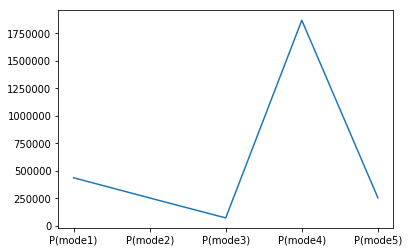

In [27]:
plt.plot(results.sum()[1:6])

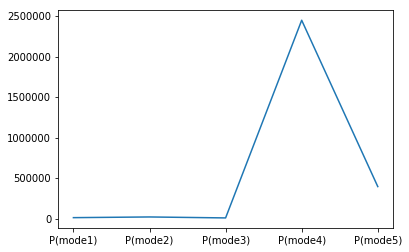

In [24]:
#fid = plt.figure(figsize=(10,10))
plt.plot(acs.sum()[1:6])

In [28]:
results.sum()[1:6]

P(mode1)         436334
P(mode2)         252645
P(mode3)        71139.1
P(mode4)    1.86806e+06
P(mode5)         253714
dtype: object

In [20]:
acs.sum()[1:6]

P(mode1)    1.073412e+04
P(mode2)    1.927840e+04
P(mode3)    7.458927e+03
P(mode4)    2.447924e+06
P(mode5)    3.942504e+05
dtype: float64